In [1]:
import gpytorch
import torch
from GPyTorch_models import DivergenceFreeSEKernel
from NN_models import dfNN

class dfNGP(gpytorch.models.ExactGP):
    # dfGP model with constant mean
    def __init__(self, train_x, train_y, likelihood):
        # Inherit from ExactGP with 3 inputs + self = 4 inputs
        super().__init__(train_x, train_y, likelihood)

        self.mean_module = dfNN()
        self.covar_module = DivergenceFreeSEKernel()
        
        # initialize hyperparameters by sampling from a uniform distribution over predefined ranges
        self.likelihood.noise = torch.zeros(1, device = device) + 0.005
        self.covar_module.outputscale = torch.ones(1, device = device) * 0.001
        self.covar_module.lengthscale = torch.ones(2, device = device)

        self.likelihood.noise_covar.register_constraint(
            "raw_noise", gpytorch.constraints.GreaterThan(1e-4)
        )

    def forward(self, x):
        # Make 2D for dfNN
        x_for_dfNN = x.reshape(2, -1).T
        mean_x_from_dfNN = self.mean_module(x_for_dfNN)
        # HACK: Reshape to interleaved format. This is counterintuitive but necessary
        mean_x = mean_x_from_dfNN.reshape(-1)

        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [47]:
import torch.nn as nn

class MLPMean(gpytorch.means.Mean):
    def __init__(self, dim):
        super(MLPMean, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(dim, 32), 
            nn.ReLU(), 
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, dim))
    
    def forward(self, x):
        m = self.mlp(x)
        print("MLPMean output shape:", m.shape)
        return m

In [ ]:
import gpytorch
import torch
from GPyTorch_models import DivergenceFreeSEKernel

import torch.nn as nn

class MLPMean(gpytorch.means.Mean):
    def __init__(self, dim):
        super(MLPMean, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(dim, 32), 
            nn.ReLU(), 
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, dim))
    
    def forward(self, x):
        m = self.mlp(x)
        print("MLPMean output shape:", m.shape)
        return m

class dfRBFKernel(gpytorch.kernel.Kernel):
    def __init__(self, **kwargs):
        super(dfRBFKernel, self).__init__(**kwargs)

        # Register the outputscale / variance (sigma_f) as a learnable parameter
        self.register_parameter(name = "raw_outputscale", 
                                parameter = torch.nn.Parameter(torch.tensor(1.0)))
        
        self.register_parameter(name = "raw_lengthscale",
                                parameter = torch.nn.Parameter(torch.tensor([1.0, 1.0])))

        # Register transform for positivity (softplus)
        self.register_constraint("raw_outputscale", gpytorch.constraints.Positive())

        self.register_constraint("raw_lengthscale", gpytorch.constraints.Positive())

    @property
    def outputscale(self):
        return self.raw_outputscale_constraint.transform(self.raw_outputscale)
    
    @property
    def lengthscale(self):
        return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)

    @outputscale.setter
    def outputscale(self, value):
        self.initialize(raw_outputscale = self.raw_outputscale_constraint.inverse_transform(value))

    @lengthscale.setter
    def lengthscale(self, value):
        self.initialize(raw_lengthscale = self.raw_lengthscale_constraint.inverse_transform(value))

    def forward(self, x1, x2, diag = False, **params):
        """
        Args:
            x1: torch.Size([2N, 1]) flattened, second explicit dim is automatic
            x2: torch.Size([2M, 1])
        Returns:
            K: torch.Size([2N, 2M])
        """
        # Transform long/flat format into 2D
        mid_x1 = x1.shape[0] // 2
        mid_x2 = x2.shape[0] // 2 

        # torch.Size([N, 2])
        x1 = torch.cat((x1[:mid_x1], x1[mid_x1:]), dim = 1).to(x1.device)
        # torch.Size([M, 2])
        x2 = torch.cat((x2[:mid_x2], x2[mid_x2:]), dim = 1).to(x2.device)

        l = self.lengthscale.squeeze().to(x1.device)  # Shape (2,)

        lx1, lx2 = l[0].to(x1.device), l[1].to(x1.device)

        sigma_f = self.outputscale

        # Broadcast pairwise differences: shape [N, M, 2]
        diff = (x1[:, None, :] - x2[None, :, :]).to(x1.device)

        ### 2x2 block components ###
        upper_left = (1 - diff[:, :, 1].square() / lx2.square()) / lx2.square()
        lower_right = (1 - diff[:, :, 0].square() / lx1.square()) / lx1.square()
        upper_right = (diff[:, :, 0] * diff[:, :, 1]) / (lx1.square() * lx2.square())
        lower_left = upper_right

        # Block matrix assembly
        top = torch.cat((upper_left, upper_right), dim = 1)
        bottom = torch.cat((lower_left, lower_right), dim = 1)
        blocks = torch.cat((top, bottom), dim = 0)

        # RBF/SE envelope (elementwise)
        exp_term = torch.exp(-0.5 * (diff.square() / l.square()).sum(dim = -1))
        # .tile(2, 2) forms (N, M) -> (2N, 2M) for the 2D vector field
        K = sigma_f.square() * blocks * exp_term.tile(2, 2)

        # Add this for Quantile Coverage Error (QCE) calculation
        if diag:
        # Return only the diagonal as a 1D tensor
            return K.diag()

        return K

class dfNGP(gpytorch.models.ExactGP):
    # dfGP model with constant mean
    def __init__(self, train_x, train_y, likelihood):
        # Inherit from ExactGP with 3 inputs + self = 4 inputs
        # train_x is in flat block shape: [x1_1, x1_2, ..., x1_n, x2_1, x2_2, ..., x2_n]
        super().__init__(train_x, train_y, likelihood)

        self.mean_module = MLPMean(dim = 2)
        self.base_module = DivergenceFreeSEKernel()
        
        # initialize hyperparameters by sampling from a uniform distribution over predefined ranges
        self.likelihood.noise = torch.zeros(1, device = device) + 0.0001
        self.covar_module.outputscale = torch.ones(1, device = device) * 0.001
        self.covar_module.lengthscale = torch.ones(2, device = device)

        self.likelihood.noise_covar.register_constraint(
            "raw_noise", gpytorch.constraints.GreaterThan(1e-4)
        )

    def forward(self, x):
        # Make 2D for dfNN
        x_for_dfNN = x.reshape(2, -1).T
        mean_x = self.mean_module(x_for_dfNN).T.reshape(-1)
        # print("x:", x_for_dfNN.shape)
        # print("mean_x shape:", mean_x.shape)

        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
from simulate import (simulate_detailed_curve,)
simulations = {"curve": simulate_detailed_curve}
x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = False).float()
from utils import make_grid
N_SIDE = 20
_, x_test = make_grid(N_SIDE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_train = simulate_detailed_curve(x_train.cpu()).to(device)
y_test = simulate_detailed_curve(x_test.cpu()).to(device)
x_test = x_test.to(device)
x_train = x_train.to(device)

likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = dfNGP(
            x_train.T.reshape(-1),
            y_train.T.reshape(-1), 
            likelihood,
            ).to(device)
model.train()
likelihood.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.AdamW([
            {"params": model.mean_module.parameters(), "weight_decay": 0.0001, "lr": (0.1)},
            # {"params": list(model.covar_module.parameters()) + list(model.likelihood.parameters()), "weight_decay": # WEIGHT_DECAY, "lr": MODEL_LEARNING_RATE},
            ])

for i in range(1000):
    optimizer.zero_grad()
    train_pred_dist = model(x_train.T.reshape(-1).to(device))
    print("HERE")
    # Train on noisy or true targets?
    loss = - mll(train_pred_dist, y_train.T.reshape(-1).to(device))  # negative marginal log likelihood
    loss.backward()
    optimizer.step()

    model.eval()
    likelihood.eval()

    print("HERE 2")
    train_pred_dist = model(x_train.T.reshape(-1).to(device))
    print("HERE 3")
    test_pred_dist = model(x_test.T.reshape(-1).to(device))
    print("HERE 4")

    train_RMSE = torch.sqrt(gpytorch.metrics.mean_squared_error(train_pred_dist, y_train.T.reshape(-1).to(device)))
    test_RMSE = torch.sqrt(gpytorch.metrics.mean_squared_error(test_pred_dist, y_test.T.reshape(-1).to(device)))
    test_mean_module_RMSE = (model.mean_module(x_test.to(device)).detach() - y_test.to(device)).norm(dim = 1).mean()

    print(f"Epoch {i + 1}, Training Loss (NLML): {loss:.4f}, (RMSE): {train_RMSE:.4f}, Test RMSE: {test_RMSE:.4f}, Test Mean Module RMSE: {test_mean_module_RMSE:.4f}")

In [49]:
# First column: 80 values from 1 to 8
col1 = torch.linspace(1, 8, steps = 80)

# Second column: 80 values from 10 to 80
col2 = torch.linspace(10, 80, steps = 80)

# Stack into a tensor of shape [80, 2]
x_tensor = torch.stack([col1, col2], dim = 1)

# shuffle formats
x_flat_block = x_tensor.T.reshape(-1)
x_two_column = x_flat_block.reshape(2, -1).T

# Build in 2D

In [ ]:
import gpytorch
import torch

class MLPMean_2D(gpytorch.means.Mean):
    def __init__(self, dim):
        super(MLPMean_2D, self).__init__()
        
        self.mlp = nn.Sequential(
            torch.nn.Linear(dim, 32), 
            torch.nn.ReLU(), 
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, dim))
    
    def forward(self, x):
        m = self.mlp(x)
        return m

class dfNN(gpytorch.means.Mean):
    # NOTE: This needs to be initialised of class gpytorch.means.Mean
    def __init__(self, input_dim = 2, hidden_dim = 32):
        # NOTE: we use the same default dimensionalities as the dfNN NN model
        super(dfNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = 1  # Scalar potential (corresponds to H in HNNs)
        
        # HACK: SiLu() worked much better than ReLU() for this gradient-based model

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, self.output_dim),
        )
    
    def forward(self, x):
        H = self.net(x)

        partials = torch.autograd.grad(
                outputs = H.sum(), # we can sum here because every H row only depend on every x row
                inputs = x,
                create_graph = True
            )[0]

        # Symplectic gradient
        # flip columns (last dim) for x2, x1 order. Multiply x2 by -1
        mean_symp = partials.flip(-1) * torch.tensor([1, -1], dtype = torch.float32, device = x.device)

        # return symp, H # NOTE: return H as well if we want to see what is going on
        return mean_symp

class dfNGP(gpytorch.models.ExactGP):
    # dfGP model with constant mean
    def __init__(self, train_x, train_y, likelihood):
        super(dfNGP, self).__init__(train_x, train_y, likelihood)

        self.mean_module = dfNN(input_dim = 2) # default hidden_dim = 32
        self.base_kernel = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        # print("mean_x shape:", mean_x.shape)
        covar_x = self.covar_module(x)
        # print("covar_x shape:", covar_x.shape)
        
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# Add dfRBFKernel

In [167]:
from typing import Optional

from gpytorch.lazy import KroneckerProductLazyTensor, lazify
from gpytorch.kernels import Kernel

class MultitaskKernelWrapper(Kernel):
    r"""
    Kernel supporting Kronecker style multitask Gaussian processes (where every data point is evaluated at every
    task) using :class:`gpytorch.kernels.IndexKernel` as a basic multitask kernel.

    Given a base covariance module to be used for the data, :math:`K_{XX}`, this kernel computes a task kernel of
    specified size :math:`K_{TT}` and returns :math:`K = K_{TT} \otimes K_{XX}`. as an
    :obj:`gpytorch.lazy.KroneckerProductLazyTensor`.

    :param ~gpytorch.kernels.Kernel data_covar_module: Kernel to use as the data kernel.
    :param int num_tasks: Number of tasks
    :param int rank: (default 1) Rank of index kernel to use for task covariance matrix.
    :param ~gpytorch.priors.Prior task_covar_prior: (default None) Prior to use for task kernel.
        See :class:`gpytorch.kernels.IndexKernel` for details.
    :param dict kwargs: Additional arguments to pass to the kernel.
    """

    def __init__(
        self,
        data_covar_module: Kernel,
        num_tasks: int,
        rank: Optional[int] = 1,
        **kwargs,
    ):
        """"""
        super(MultitaskKernelWrapper, self).__init__(**kwargs)
        self.data_covar_module = data_covar_module
        self.num_tasks = num_tasks

    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            raise RuntimeError("MultitaskKernel does not accept the last_dim_is_batch argument.")
        covar_x = lazify(self.data_covar_module.forward(x1, x2, **params))
        return covar_x.diag() if diag else covar_x

    def num_outputs_per_input(self, x1, x2):
        """
        Given `n` data points `x1` and `m` datapoints `x2`, this multitask
        kernel returns an `(n*num_tasks) x (m*num_tasks)` covariance matrix.
        """
        return self.num_tasks

In [208]:
class dfRBFKernel(gpytorch.kernels.Kernel):
    def __init__(self, num_tasks = 2, **kwargs):
        super().__init__(num_tasks = num_tasks, **kwargs)
        self.num_tasks = num_tasks
        
        self.register_parameter(name = "raw_lengthscale",
                                parameter = torch.nn.Parameter(torch.tensor([1.0, 1.0])))

        self.register_constraint("raw_lengthscale", gpytorch.constraints.Positive())

    @property
    def outputscale(self):
        return self.raw_outputscale_constraint.transform(self.raw_outputscale)
    
    @property
    def lengthscale(self):
        return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)

    @outputscale.setter
    def outputscale(self, value):
        self.initialize(raw_outputscale = self.raw_outputscale_constraint.inverse_transform(value))

    @lengthscale.setter
    def lengthscale(self, value):
        self.initialize(raw_lengthscale = self.raw_lengthscale_constraint.inverse_transform(value))

    def forward(self, row_tensor, column_tensor, diag = False, **params):
        """
        Args:
            row_tensor: torch.Size([N, 2]) first input will correspond to rows in returned K
            column_tensor: torch.Size([M, 2]) second input will correspond to columns in returned K
            diag: bool, if True, return only the diagonal of the covariance matrix
        Returns:
            K: torch.Size([2N, 2M])
        """
        # Extract the chosen device
        device = row_tensor.device

        # Remove second explicit dim to get Shape: (2,)
        l = self.lengthscale.squeeze().to(device)
        # Extract both lengthscales
        l1, l2 = l[0], l[1]

        # STEP 1: Pairwise differences of shape [N, M, 2]
        # Expand row_tensor [N, 2] -> [N, 1, 2] and column_tensor [M, 2] -> [1, M, 2]
        diff = (row_tensor[:, None, :] - column_tensor[None, :, :]).to(device)
        # Extract the components (columns) for convenience, matching paper notation
        r1 = diff[:, :, 0]
        r2 = diff[:, :, 1]

        # STEP 2: Block matrix
        # Compute the 4 (2x2) block components
        upper_left = l2.square() - r2.square()
        lower_right = l1.square() - r1.square()
        upper_right = r1 * r2
        lower_left = upper_right # symmetric

        # Assemble the 2x2 block matrix
        top = torch.cat((upper_left, upper_right), dim = 1) # Shape: [N, 2M]
        bottom = torch.cat((lower_left, lower_right), dim = 1) # Shape: [N, 2M]
        blocks = torch.cat((top, bottom), dim = 0) # Shape: [2N, 2M]

        # STEP 3: RBF/SE envelope (elementwise)
        exponent_term = torch.exp(-0.5 * ((r1 / l1) ** 2 + (r2 / l2) ** 2))  # Shape: [N, M]
        
        # .tile(2, 2) forms (N, M) -> (2N, 2M) for the 2D vector field
        K = (1 / (l1**2 * l2**2)) * blocks * exponent_term.tile(2, 2)

        # Add this for Quantile Coverage Error (QCE) calculation
        if diag:
            # Return only the diagonal as a 1D tensor
            return K.diag()

        return K

class dfNN(gpytorch.means.Mean):
    # NOTE: This needs to be initialised of class gpytorch.means.Mean
    def __init__(self, input_dim = 2, hidden_dim = 32):
        # NOTE: we use the same default dimensionalities as the dfNN NN model
        super(dfNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = 1  # Scalar potential (corresponds to H in HNNs)
        
        # HACK: SiLu() worked much better than ReLU() for this gradient-based model

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, self.output_dim),
        )
    
    def forward(self, x):
        H = self.net(x)

        partials = torch.autograd.grad(
                outputs = H.sum(), # we can sum here because every H row only depend on every x row
                inputs = x,
                create_graph = True
            )[0]

        # Symplectic gradient
        # flip columns (last dim) for x2, x1 order. Multiply x2 by -1
        mean_symp = partials.flip(-1) * torch.tensor([1, -1], dtype = torch.float32, device = x.device)

        # return symp, H # NOTE: return H as well if we want to see what is going on
        return mean_symp

class dfNGP(gpytorch.models.ExactGP):
    # dfGP model with constant mean
    def __init__(self, train_x, train_y, likelihood):
        super(dfNGP, self).__init__(train_x, train_y, likelihood)

        # Custom mean module
        self.mean_module = dfNN(input_dim = 2) # default hidden_dim = 32
        # Custom kernel module
        self.base_kernel = MultitaskKernelWrapper(
            dfRBFKernel(num_tasks = 2), 
            num_tasks = 2,
            )

        # self.base_kernel = dfRBFKernel(num_tasks = 2)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)

        self.covar_module.outputscale = torch.ones(1, device = device) * 0.001

    def forward(self, x):
        mean_x = self.mean_module(x)
        # print("mean_x shape:", mean_x.shape)
        covar_x = self.covar_module(x)
        # print("covar_x shape:", covar_x.shape)
        
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [209]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from simulate import (simulate_detailed_curve,)
simulations = {"curve": simulate_detailed_curve}

from utils import make_grid
N_SIDE = 20
_, x_test = make_grid(N_SIDE)
x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = False).float()

y_train = simulate_detailed_curve(x_train.cpu()).to(device)
y_test = simulate_detailed_curve(x_test.cpu()).to(device)

x_test = x_test.to(device)
x_train = x_train.to(device)

# likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks = 2).to(device)

model = dfNGP(
            x_train,
            y_train, 
            likelihood,
            ).to(device)

for name, param in likelihood.named_parameters():
    print(name, param.shape)

# likelihood.raw_task_noises

for name, param in model.named_parameters():
    print(name, param.shape)

# We can actually set it as such
# model.covar_module.outputscale = 0.001
# print(model.covar_module.raw_outputscale)
# print(model.covar_module.outputscale)

# Set to not require grad
# model.covar_module.raw_outputscale.requires_grad_(False)

model.train()
likelihood.train()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

optimizer = torch.optim.AdamW([
            {"params": model.mean_module.parameters(), "weight_decay": 0.0001, "lr": 0.05},
            # {"params": list(model.covar_module.parameters()) + list(model.likelihood.parameters()), "weight_decay": # WEIGHT_DECAY, "lr": MODEL_LEARNING_RATE},
            ])

for i in range(1000):
    optimizer.zero_grad()
    train_pred_dist = model(x_train.to(device))
    # Train on noisy or true targets?
    loss = - mll(train_pred_dist, y_train.to(device))  # negative marginal log likelihood
    loss.backward()
    optimizer.step()

    model.eval()
    likelihood.eval()

    train_pred_dist = model(x_train.to(device))
    test_pred_dist = model(x_test.to(device))

    train_RMSE = torch.sqrt(torch.mean(torch.square(train_pred_dist.mean - y_train)))
    test_RMSE = torch.sqrt(torch.mean(torch.square(test_pred_dist.mean - y_test)))
    test_mean_module_RMSE = torch.sqrt(torch.mean(torch.square(model.mean_module(x_test.to(device)).detach() - y_test.to(device))))

    print(f"Epoch {i + 1} Training Loss (NLML): {loss:.4f} Train RMSE: {train_RMSE:.4f} Test RMSE: {test_RMSE:.4f}, Test Mean Module RMSE: {test_mean_module_RMSE:.4f}")

raw_task_noises torch.Size([2])
raw_noise torch.Size([1])
likelihood.raw_task_noises torch.Size([2])
likelihood.raw_noise torch.Size([1])
mean_module.net.0.weight torch.Size([32, 2])
mean_module.net.0.bias torch.Size([32])
mean_module.net.2.weight torch.Size([32, 32])
mean_module.net.2.bias torch.Size([32])
mean_module.net.4.weight torch.Size([1, 32])
mean_module.net.4.bias torch.Size([1])
base_kernel.data_covar_module.raw_lengthscale torch.Size([2])
covar_module.raw_outputscale torch.Size([])
Epoch 1 Training Loss (NLML): 1.4876 Train RMSE: 0.6641 Test RMSE: 0.7849, Test Mean Module RMSE: 0.8084
Epoch 2 Training Loss (NLML): 1.2366 Train RMSE: 0.4072 Test RMSE: 0.4399, Test Mean Module RMSE: 0.4355
Epoch 3 Training Loss (NLML): 1.1417 Train RMSE: 0.6143 Test RMSE: 0.5901, Test Mean Module RMSE: 0.5700


/home/kim/anaconda3/envs/ice_thickness_gpytorch/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
/home/kim/anaconda3/envs/ice_thickness_gpytorch/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Epoch 4 Training Loss (NLML): 1.2141 Train RMSE: 0.3435 Test RMSE: 0.4031, Test Mean Module RMSE: 0.4064
Epoch 5 Training Loss (NLML): 1.1250 Train RMSE: 0.4438 Test RMSE: 0.5582, Test Mean Module RMSE: 0.5784
Epoch 6 Training Loss (NLML): 1.1521 Train RMSE: 0.4983 Test RMSE: 0.6132, Test Mean Module RMSE: 0.6353
Epoch 7 Training Loss (NLML): 1.1697 Train RMSE: 0.4057 Test RMSE: 0.5120, Test Mean Module RMSE: 0.5320
Epoch 8 Training Loss (NLML): 1.1407 Train RMSE: 0.2850 Test RMSE: 0.3605, Test Mean Module RMSE: 0.3702
Epoch 9 Training Loss (NLML): 1.1118 Train RMSE: 0.3635 Test RMSE: 0.3791, Test Mean Module RMSE: 0.3685
Epoch 10 Training Loss (NLML): 1.1293 Train RMSE: 0.4100 Test RMSE: 0.4187, Test Mean Module RMSE: 0.4046
Epoch 11 Training Loss (NLML): 1.1417 Train RMSE: 0.3098 Test RMSE: 0.3453, Test Mean Module RMSE: 0.3404
Epoch 12 Training Loss (NLML): 1.1167 Train RMSE: 0.2769 Test RMSE: 0.3564, Test Mean Module RMSE: 0.3672
Epoch 13 Training Loss (NLML): 1.1101 Train RMSE: 0.

In [ ]:
likelihood.eval()
likelihood.raw_task_noises
likelihood.task_noises

model.covar_module.outputscale

tensor(0.6931, device='cuda:0', grad_fn=<SoftplusBackward0>)

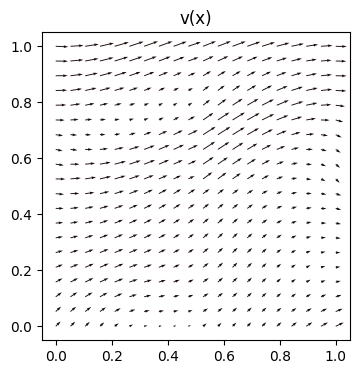

In [188]:
from visualise import visualise_v_quiver

mean_model_out = model.mean_module(x_test.to(device)).detach()

visualise_v_quiver(
    test_pred_dist.mean,
    x_test)

In [178]:
likelihood(test_pred_dist).mean - test_pred_dist.mean

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

In [175]:
test_pred_dist.mean - mean_model_out

tensor([[0.7644, 0.7659],
        [0.7662, 0.7651],
        [0.7627, 0.7591],
        [0.7542, 0.7480],
        [0.7406, 0.7320],
        [0.7222, 0.7113],
        [0.6994, 0.6864],
        [0.6724, 0.6576],
        [0.6419, 0.6254],
        [0.6083, 0.5905],
        [0.7789, 0.7809],
        [0.7816, 0.7809],
        [0.7789, 0.7755],
        [0.7708, 0.7647],
        [0.7574, 0.7488],
        [0.7390, 0.7280],
        [0.7158, 0.7026],
        [0.6884, 0.6732],
        [0.6571, 0.6402],
        [0.6226, 0.6043],
        [0.7907, 0.7932],
        [0.7942, 0.7939],
        [0.7922, 0.7890],
        [0.7845, 0.7786],
        [0.7714, 0.7628],
        [0.7529, 0.7418],
        [0.7295, 0.7161],
        [0.7016, 0.6861],
        [0.6697, 0.6524],
        [0.6343, 0.6155],
        [0.7998, 0.8026],
        [0.8041, 0.8041],
        [0.8026, 0.7997],
        [0.7954, 0.7896],
        [0.7824, 0.7739],
        [0.7640, 0.7529],
        [0.7404, 0.7268],
        [0.7121, 0.6963],
        [0.6

In [173]:
torch.set_printoptions(sci_mode = False)
test_pred_dist_likeli = likelihood(test_pred_dist)
test_pred_dist_likeli.mean.reshape(2, -1).T - mean_model_out

tensor([[     0.7644,      1.9055],
        [     0.5802,      0.0026],
        [     0.8037,      1.8130],
        [     0.7528,      0.1417],
        [     0.7647,      2.0711],
        [     0.8023,      0.6639],
        [     0.7512,      2.4637],
        [     0.8062,      0.9762],
        [     0.8091,      2.4176],
        [     0.6901,      0.9267],
        [     0.8289,      2.1596],
        [     0.4711,      0.8379],
        [     0.7856,      1.9160],
        [     0.2825,      0.8057],
        [     0.6993,      1.7157],
        [     0.1883,      0.8185],
        [     0.5814,      1.5591],
        [     0.1468,      0.8689],
        [     0.4246,      1.4624],
        [     0.0880,      0.9589],
        [     0.3032,      1.8953],
        [     0.1624,      1.3340],
        [     0.2863,      1.5895],
        [     0.2196,      1.2484],
        [     0.2588,      1.6623],
        [     0.2735,      1.4566],
        [     0.3149,      1.8483],
        [     0.4094,      1